# Imports

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from pymdp import utils
from pymdp.maths import softmax
from pymdp.maths import spm_log_single as log_stable
from pymdp.control import construct_policies

# Plotting

In [74]:
def plot_likelihood(matrix, xlabels = list(range(9)), ylabels = list(range(9)), title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, xticklabels = xlabels, yticklabels = ylabels, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()

def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_point_on_grid(state_vector, grid_locations):
    """
    Plots the current location of the agent on the grid world
    """
    state_index = np.where(state_vector)[0][0]
    y, x = grid_locations[state_index]
    grid_heatmap = np.zeros((3,3))
    grid_heatmap[y,x] = 1.0
    sns.heatmap(grid_heatmap, cbar = False, fmt='.0f')

def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

# Tutorial

In [75]:
grid_locations = list(itertools.product(range(3), repeat = 2))

n_states = len(grid_locations)
n_observations = len(grid_locations)

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [81]:
def infer_states(observation_index, A, prior):
  
  log_likelihood = log_stable(A[observation_index,:])

  log_prior = log_stable(prior)

  qs = softmax(log_likelihood + log_prior)
   
  return qs

def get_expected_states(B, qs_current, action):
  qs_u = B[:,:,action].dot(qs_current)

  return qs_u

def get_expected_observations(A, qs_u):

  qo_u = A.dot(qs_u)

  return qo_u

def entropy(A):

  H_A = - (A * log_stable(A)).sum(axis=0)

  return H_A

def kl_divergence(qo_u, C):
  
  return (log_stable(qo_u) - log_stable(C)).dot(qo_u)

def calculate_G(A, B, C, qs_current, actions):

  G = np.zeros(len(actions)) # vector of expected free energies, one per action

  H_A = entropy(A) # entropy of the observation model, P(o|s)

  for action_i in range(len(actions)):
    
    qs_u = get_expected_states(B, qs_current, action_i) # expected states, under the action we're currently looping over
    qo_u = get_expected_observations(A, qs_u)           # expected observations, under the action we're currently looping over

    pred_uncertainty = H_A.dot(qs_u) # predicted uncertainty, i.e. expected entropy of the A matrix
    pred_div = kl_divergence(qo_u, C) # predicted divergence

    G[action_i] = pred_uncertainty + pred_div # sum them together to get expected free energy
  
  return G

def create_B_matrix():
  B = np.zeros( (len(grid_locations), len(grid_locations), len(actions)) )

  for action_id, action_label in enumerate(actions):

    for curr_state, grid_location in enumerate(grid_locations):

      y, x = grid_location

      if action_label == "UP":
        next_y = y - 1 if y > 0 else y 
        next_x = x
      elif action_label == "DOWN":
        next_y = y + 1 if y < 2 else y 
        next_x = x
      elif action_label == "LEFT":
        next_x = x - 1 if x > 0 else x 
        next_y = y
      elif action_label == "RIGHT":
        next_x = x + 1 if x < 2 else x 
        next_y = y
      elif action_label == "STAY":
        next_x = x
        next_y = y
      new_location = (next_y, next_x)
      next_state = grid_locations.index(new_location)
      B[next_state, curr_state, action_id] = 1.0
  return B


In [78]:
class GridWorldEnv():

    def __init__(self, starting_state=(0, 0)) -> None:

        self.init_state = starting_state
        self.current_state = self.init_state
        print(f'Starting state is {starting_state}')
    
    def step(self, action_label):

        (Y, X) = self.current_state

        if action_label == "UP": 
          
          Y_new = Y - 1 if Y > 0 else Y
          X_new = X

        elif action_label == "DOWN": 

          Y_new = Y + 1 if Y < 2 else Y
          X_new = X

        elif action_label == "LEFT": 
          Y_new = Y
          X_new = X - 1 if X > 0 else X

        elif action_label == "RIGHT": 
          Y_new = Y
          X_new = X +1 if X < 2 else X

        elif action_label == "STAY":
          Y_new, X_new = Y, X 

        self.current_state = (Y_new, X_new)

        obs = self.current_state

        return obs
    
    def reset(self):
        self.current_state = self.init_state
        print(f'Re-initialized location to {self.init_state}')
        obs = self.current_state
        print(f'..and sampled observation {obs}')

        return obs

Starting state is (0, 0)


In [85]:
A = np.eye(n_observations, n_states)

B = create_B_matrix()

C = utils.onehot(grid_locations.index( (2, 2) ), n_observations) # make the agent prefer location (2,2) (lower right corner of grid world)

D = utils.onehot(grid_locations.index( (0,0) ), n_states) # start the agent with the prior belief that it starts in location (1,2) 

actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

env = GridWorldEnv(starting_state = (0,0))

Starting state is (0, 0)


Re-initialized location to (0, 0)
..and sampled observation (0, 0)
Time 0: Agent observes itself in location: (0, 0)


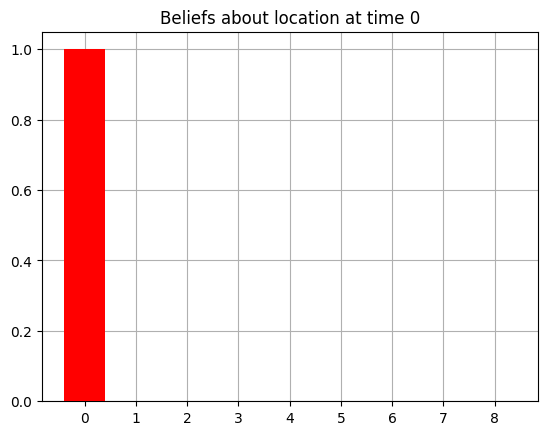

Time 1: Agent observes itself in location: (0, 0)


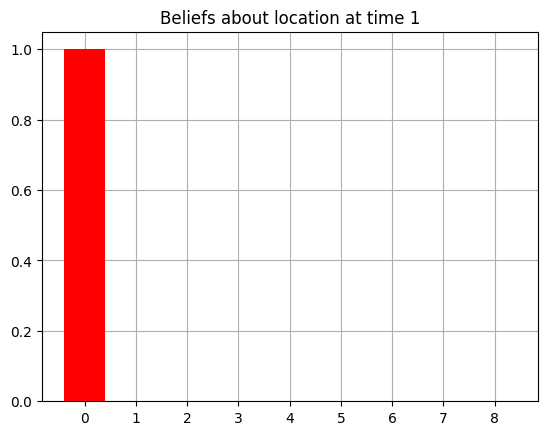

Time 2: Agent observes itself in location: (0, 0)


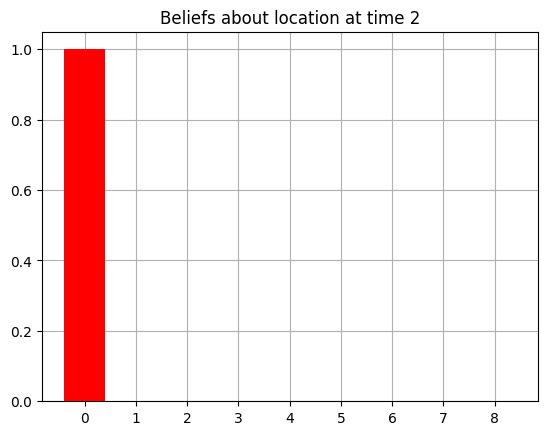

Time 3: Agent observes itself in location: (1, 0)


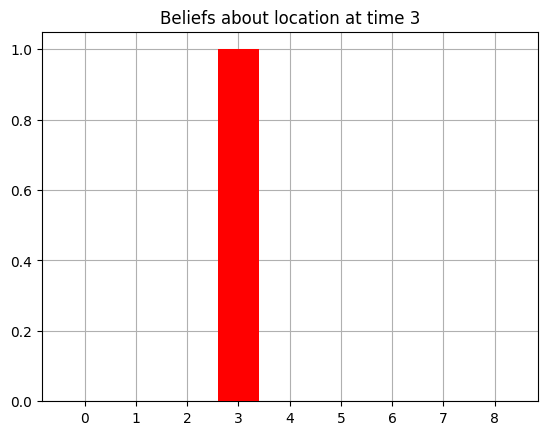

Time 4: Agent observes itself in location: (0, 0)


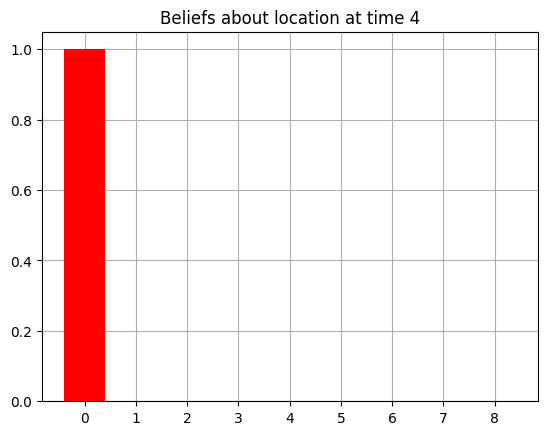

In [86]:
def run_active_inference_loop(A, B, C, D, actions, env, T = 5):

  """ Initialize the prior that will be passed in during inference to be the same as `D` """
  prior = D.copy() # initial prior should be the D vector

  """ Initialize the observation that will be passed in during inference - hint use env.reset()"""
  obs = env.reset() # initialize the `obs` variable to be the first observation you sample from the environment, before `step`-ing it.

  for t in range(T):

    print(f'Time {t}: Agent observes itself in location: {obs}')

    # convert the observation into the agent's observational state space (in terms of 0 through 8)
    obs_idx = grid_locations.index(obs)

    # perform inference over hidden states
    qs_current = infer_states(obs_idx, A, prior)

    plot_beliefs(qs_current, title_str = f"Beliefs about location at time {t}")

    # calculate expected free energy of actions
    G = calculate_G(A, B, C, qs_current, actions)
    
    # compute action posterior
    Q_u = softmax(-G)

    # sample action from probability distribution over actions
    chosen_action = utils.sample(Q_u)

    # compute prior for next timestep of inference
    prior = B[:,:,chosen_action].dot(qs_current) 

    # update generative process
    action_label = actions[chosen_action]

    obs = env.step(action_label)
  
  return qs_current

""" Run the function we just wrote, for T = 5 timesteps """
qs = run_active_inference_loop(A, B, C, D, actions, env, T = 5)

In [93]:
policy_len = 2
n_actions = len(actions)

# we have to wrap `n_states` and `n_actions` in a list for reasons that will become clear in Part II
all_policies = construct_policies([n_states], [n_actions], policy_len = policy_len)
print(all_policies[0])

[[0]
 [0]]
